# **Introduction** 

For this project we will be looking at classifying disaster tweets. We have a dataset of tweets that describe one of two things: A disaster, or not a disaster. The dataset set is labeled 1 for disaster, and 0 for not a disaster. Included with this project we have the following files:
- train.csv: csv file that contains the training dataset with columns id, text, location, keyword , target 
- test.csv: a csv file that contains columns id, text, location, keyword 
We will be using train.csv to train our model and test.csv to submit our solution. 

For this problem we will look at using models in the RNN family (Vanilla RNN, LSTM, GRU) and compare the results. 

In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix , ConfusionMatrixDisplay
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# EDA
For the EDA we will 
1. Inspect the DataFrames and sample some text 
2. View the wordcount distribution to understand the size of our inputs
3. Process the text by removing stop words, removing special characters, and changing all characters to lowercase

In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['word_count']

0       13
1        7
2       22
3        8
4       16
        ..
7608    11
7609    20
7610     8
7611    19
7612    13
Name: word_count, Length: 7613, dtype: int64

<Axes: >

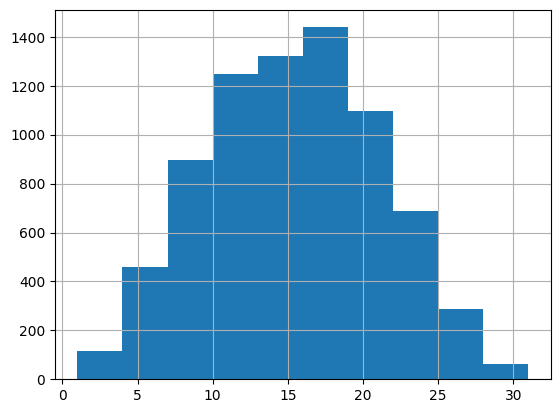

In [6]:
train_df['word_count'].hist()

The text lengths seem to top out around 30 words, gotta love twitter character limits

## process text

In [7]:
import nltk 
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:

def process_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    processed_tokens = [token for token in tokens if token not in stop_words]
    processed_text = ' '.join(processed_tokens)
    return processed_text

In [9]:
train_df['reduced_text'] = train_df['text'].apply(lambda x: process_text(x))

In [10]:
train_df['reduced_text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    aria_ahrary thetawniest control wild fires cal...
7610    m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: reduced_text, Length: 7613, dtype: object

<Axes: >

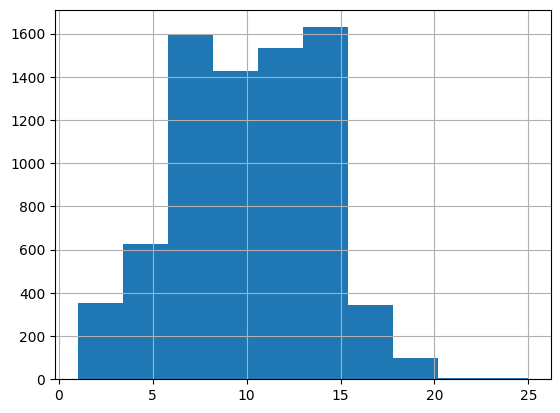

In [11]:
train_df['reduced_count'] = train_df['reduced_text'].apply(lambda x: len(x.split()))
train_df['reduced_count'].hist()

After processing the text, we got a decent reduction in words. This should remove unnecessary information

# Dataloaders

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:


# Assuming you have a list of texts and labels
texts = train_df['reduced_text'].to_list()
labels = train_df['target'].to_list()

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization and vocabulary building
tokenizer = get_tokenizer('basic_english')


In [14]:

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_texts), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])


In [15]:
# Dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor([vocab[token] for token in tokenizer(text)]) for text in texts]
        self.labels = [torch.tensor(label) for label in labels]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [16]:
# Create datasets
train_dataset = TextClassificationDataset(train_texts, train_labels)
val_dataset = TextClassificationDataset(val_texts, val_labels)
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: zip(*x))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: zip(*x))

# Models

## Vanilla RNN Model

![RNN](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ8iHvAYCgf15zBhZ5bJiuOUmOWVml4e5Bo2g&s)

Image credit to https://www.catalyzex.com/paper/deep-bidirectional-and-unidirectional-lstm

The RNN model is the simplist form of the deep recurrent neural networks. The RNN module contains a recurrent connection, looping through the outputs to create a hidden state that can pass information to future indexes in the sequence. For each iteration the input vector is combined with the previous hidden state, the result of that combination creates the next hidden state. This continues until the sequence is complete and the output is put through a linear layer for classification. 

In [17]:
class VanillaRNNClassifier(nn.Module):
    def __init__(self, vocab_size=100, embedding_dim=100, hidden_dim=256, output_dim=2, n_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        return self.fc(hidden[-1,:,:])

## LSTM Model
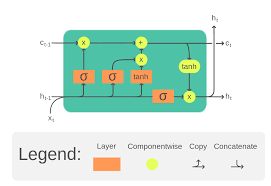

image credit to: https://en.wikipedia.org/wiki/Long_short-term_memory

The Long Short-Term Memory (LSTM) model was designed to address the vanishing gradient problem with vanilla RNNS. It performs similarily to the RNN model, however it adds a cell state and gates. The sell state contains information that can be seen throughout the sequence. The gates regulate information flow and are comprised of a forget gate, an input gate and an output gate. The forget gate desides what information to discard from the cell state. The input gate determines what new information to store in the cell state. The output gate decides what to output based on the cell state. Like the RNN the result of this sequence is passed to a linear layer for classification

In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size=100, embedding_dim=100, hidden_dim=256, output_dim=2, n_layers=2, bidirectional=True, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        return self.fc(self.dropout(hidden))


## GRU Model
![GRU Model](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Gated_Recurrent_Unit%2C_base_type.svg/220px-Gated_Recurrent_Unit%2C_base_type.svg.png)

Image credit to: https://en.wikipedia.org/wiki/Gated_recurrent_unit

A Gated Recurrent Unit (GRU) model is like an LSTM model in terms of its implementation of gating features, but with fewer parameters. A GRU only contains an update gate, and a reset gate. An update gates simply decides what information to keep. A Reset gate determines how much information to forget. 

In [19]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size=100, embedding_dim=100, hidden_dim=256, output_dim=2, n_layers=2, bidirectional=True, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bias=True, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        if self.gru.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        x = self.fc(self.dropout(hidden))
        x = self.leakyrelu(x)
        
        return self.fc2(x)


# Training

For training we will compare 
1. Vanilla RNN 
2. LSTM 
3. GRU

In [20]:
# Training function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for texts, labels in iterator:
        optimizer.zero_grad()
        texts = nn.utils.rnn.pad_sequence(texts, batch_first=True).to(device)
        predictions = model(texts).squeeze(1)
        labels = torch.tensor(list(labels)).to(device)
        loss = criterion(predictions, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


In [21]:
# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for texts, labels in iterator:
            texts = nn.utils.rnn.pad_sequence(texts, batch_first=True).to(device)
            predictions = model(texts).squeeze(1)
            labels = torch.tensor(list(labels)).to(device)
            loss = criterion(predictions, labels.float())
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)


In [22]:

# Function to predict on new text
def predict(model, text):
    model.eval()
    tokens = torch.tensor([vocab[token] for token in tokenizer(text)]).to(device)
    prediction = model(tokens.unsqueeze(0)).squeeze(1)
    return torch.sigmoid(prediction).item()

In [23]:
def run_training(model, train_loader, val_loader, optimizer, criterion, n_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss) 
        val_losses.append(val_loss)
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {val_loss:.3f}')
    return train_losses, val_losses

## Vanilla RNN Training

In [73]:

# Initialize the model
model = VanillaRNNClassifier(vocab_size=len(vocab), embedding_dim=128, hidden_dim=128, output_dim=1, n_layers=3, dropout=0.1)
model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 15
losses = run_training(model, train_loader, val_loader, optimizer,  criterion, epochs)

Epoch: 01
	Train Loss: 0.684
	 Val. Loss: 0.678
Epoch: 02
	Train Loss: 0.676
	 Val. Loss: 0.660
Epoch: 03
	Train Loss: 0.647
	 Val. Loss: 0.627
Epoch: 04
	Train Loss: 0.622
	 Val. Loss: 0.624
Epoch: 05
	Train Loss: 0.600
	 Val. Loss: 0.620
Epoch: 06
	Train Loss: 0.584
	 Val. Loss: 0.597
Epoch: 07
	Train Loss: 0.569
	 Val. Loss: 0.608
Epoch: 08
	Train Loss: 0.551
	 Val. Loss: 0.605
Epoch: 09
	Train Loss: 0.533
	 Val. Loss: 0.584
Epoch: 10
	Train Loss: 0.523
	 Val. Loss: 0.601
Epoch: 11
	Train Loss: 0.500
	 Val. Loss: 0.571
Epoch: 12
	Train Loss: 0.486
	 Val. Loss: 0.587
Epoch: 13
	Train Loss: 0.477
	 Val. Loss: 0.607
Epoch: 14
	Train Loss: 0.459
	 Val. Loss: 0.570
Epoch: 15
	Train Loss: 0.448
	 Val. Loss: 0.610


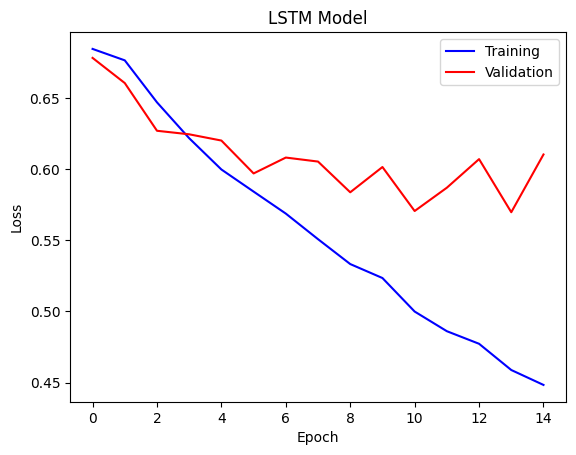

In [74]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.plot(losses[0], 'b-', label='Training')
ax.plot(losses[1], 'r-', label='Validation')
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('LSTM Model')
fig.show()

In [75]:
predictions = []
for val_text in val_texts:
    pred = predict(model, val_text)
    if pred > 0.5:
        pred = 1 
    else:
        pred = 0
    predictions.append(pred)

0.7051871306631649
[[756 118]
 [331 318]]


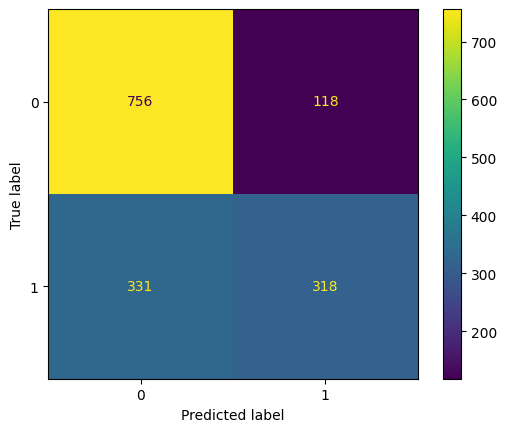

In [76]:
acc = accuracy_score(val_labels, predictions)
cm = confusion_matrix(val_labels, predictions)
print(acc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## LSTM Training

In [77]:

# Initialize the model
model = LSTMClassifier(vocab_size=len(vocab), embedding_dim=128, hidden_dim=128, output_dim=1, n_layers=3, bidirectional=False, dropout=0.1)
model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 15
losses = run_training(model, train_loader, val_loader, optimizer,  criterion, epochs)


Epoch: 01
	Train Loss: 0.683
	 Val. Loss: 0.672
Epoch: 02
	Train Loss: 0.672
	 Val. Loss: 0.660
Epoch: 03
	Train Loss: 0.641
	 Val. Loss: 0.605
Epoch: 04
	Train Loss: 0.577
	 Val. Loss: 0.561
Epoch: 05
	Train Loss: 0.521
	 Val. Loss: 0.536
Epoch: 06
	Train Loss: 0.474
	 Val. Loss: 0.549
Epoch: 07
	Train Loss: 0.430
	 Val. Loss: 0.610
Epoch: 08
	Train Loss: 0.394
	 Val. Loss: 0.543
Epoch: 09
	Train Loss: 0.348
	 Val. Loss: 0.531
Epoch: 10
	Train Loss: 0.316
	 Val. Loss: 0.557
Epoch: 11
	Train Loss: 0.290
	 Val. Loss: 0.574
Epoch: 12
	Train Loss: 0.272
	 Val. Loss: 0.595
Epoch: 13
	Train Loss: 0.246
	 Val. Loss: 0.566
Epoch: 14
	Train Loss: 0.226
	 Val. Loss: 0.674
Epoch: 15
	Train Loss: 0.217
	 Val. Loss: 0.612


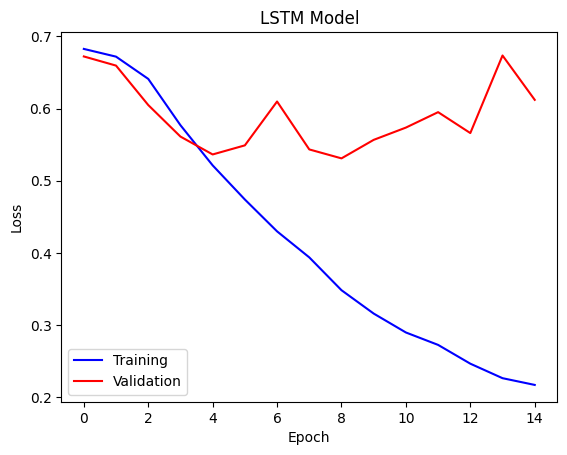

In [78]:

fig, ax = plt.subplots()
ax.plot(losses[0], 'b-', label='Training')
ax.plot(losses[1], 'r-', label='Validation')
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('LSTM Model')
fig.show()

In [79]:
predictions = []
for val_text in val_texts:
    pred = predict(model, val_text)
    if pred > 0.5:
        pred = 1 
    else:
        pred = 0
    predictions.append(pred)

0.7616546290216678
[[780  94]
 [269 380]]


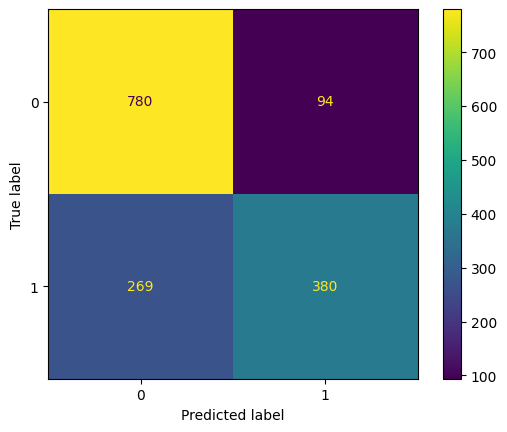

In [80]:

acc = accuracy_score(val_labels, predictions)
cm = confusion_matrix(val_labels, predictions)
print(acc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## GRU Training

In [93]:

# Initialize the model
model = GRUClassifier(vocab_size=len(vocab), embedding_dim=128, hidden_dim=256, output_dim=1, n_layers=3, bidirectional=False, dropout=0.1)
model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 15
losses = run_training(model, train_loader, val_loader, optimizer,  criterion, epochs)



Epoch: 01
	Train Loss: 0.679
	 Val. Loss: 0.666
Epoch: 02
	Train Loss: 0.631
	 Val. Loss: 0.601
Epoch: 03
	Train Loss: 0.567
	 Val. Loss: 0.581
Epoch: 04
	Train Loss: 0.521
	 Val. Loss: 0.550
Epoch: 05
	Train Loss: 0.474
	 Val. Loss: 0.546
Epoch: 06
	Train Loss: 0.422
	 Val. Loss: 0.556
Epoch: 07
	Train Loss: 0.375
	 Val. Loss: 0.549
Epoch: 08
	Train Loss: 0.332
	 Val. Loss: 0.567
Epoch: 09
	Train Loss: 0.304
	 Val. Loss: 0.553
Epoch: 10
	Train Loss: 0.285
	 Val. Loss: 0.666
Epoch: 11
	Train Loss: 0.250
	 Val. Loss: 0.607
Epoch: 12
	Train Loss: 0.218
	 Val. Loss: 0.646
Epoch: 13
	Train Loss: 0.203
	 Val. Loss: 0.691
Epoch: 14
	Train Loss: 0.181
	 Val. Loss: 0.664
Epoch: 15
	Train Loss: 0.173
	 Val. Loss: 0.682


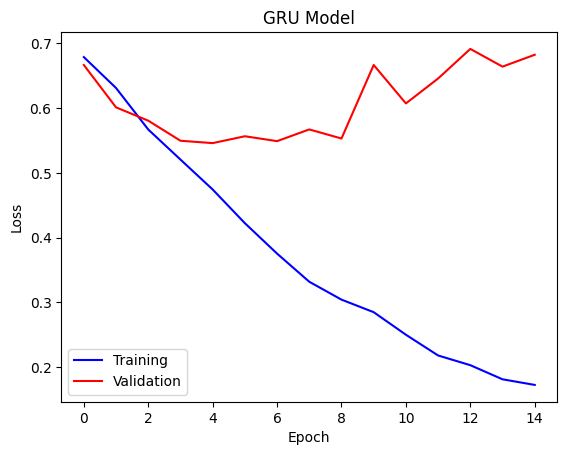

In [94]:


fig, ax = plt.subplots()
ax.plot(losses[0], 'b-', label='Training')
ax.plot(losses[1], 'r-', label='Validation')
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('GRU Model')
fig.show()

In [95]:
predictions = []
for val_text in val_texts:
    pred = predict(model, val_text)
    if pred > 0.5:
        pred = 1 
    else:
        pred = 0
    predictions.append(pred)

0.7557452396585687
[[800  74]
 [298 351]]


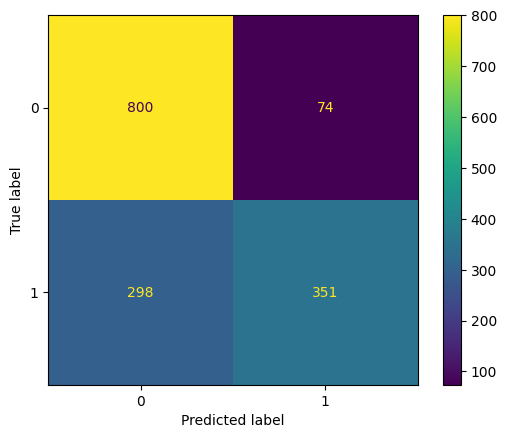

In [96]:
acc = accuracy_score(val_labels, predictions)
cm = confusion_matrix(val_labels, predictions)
print(acc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Hyperparameter tuning

For hyperparameter tuning, I am going to just use a basic grid search due to resource and time constraints. Additionally, I will only perform tuning on the GRU model due to its promising performance. In practice you may want to use a more exhaustive search algorithm.

In [36]:
import itertools
from sklearn.model_selection import ParameterGrid

In [37]:
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader):
  n_epochs = 20
  loss = run_training(model, train_loader, val_loader, optimizer, criterion, n_epochs)
  return loss[1][-1]

def grid_search(model_class, param_grid, train_loader, val_loader):
  results = []
  for params in tqdm(ParameterGrid(param_grid)):
    model = model_class(vocab_size=len(vocab), embedding_dim=params['embedding_dim'], hidden_dim=params['hidden_dim'], output_dim=1, n_layers=params['n_layers'], bidirectional=params['bidirectional'], dropout=params['dropout'])
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.BCEWithLogitsLoss()
    val_accuracy = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader)
    results.append({**params, 'val_loss': val_accuracy})

  return results

In [38]:


param_grid = {
    'embedding_dim': [128],
    'hidden_dim': [32, 64, 128],
    'n_layers': [2, 3],
    'dropout': [0.1, 0.4],
    'bidirectional': [True, False], 
    'lr': [1e-4],

}
lstm_parameter_results = grid_search(GRUClassifier, param_grid, train_loader, val_loader)

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 0.684
	 Val. Loss: 0.673
Epoch: 02
	Train Loss: 0.673
	 Val. Loss: 0.661
Epoch: 03
	Train Loss: 0.655
	 Val. Loss: 0.643
Epoch: 04
	Train Loss: 0.629
	 Val. Loss: 0.644
Epoch: 05
	Train Loss: 0.595
	 Val. Loss: 0.620
Epoch: 06
	Train Loss: 0.559
	 Val. Loss: 0.620
Epoch: 07
	Train Loss: 0.528
	 Val. Loss: 0.591
Epoch: 08
	Train Loss: 0.499
	 Val. Loss: 0.590
Epoch: 09
	Train Loss: 0.471
	 Val. Loss: 0.613
Epoch: 10
	Train Loss: 0.448
	 Val. Loss: 0.577
Epoch: 11
	Train Loss: 0.418
	 Val. Loss: 0.579
Epoch: 12
	Train Loss: 0.402
	 Val. Loss: 0.606
Epoch: 13
	Train Loss: 0.387
	 Val. Loss: 0.587
Epoch: 14
	Train Loss: 0.365
	 Val. Loss: 0.612
Epoch: 15
	Train Loss: 0.347
	 Val. Loss: 0.618
Epoch: 16
	Train Loss: 0.333
	 Val. Loss: 0.661
Epoch: 17
	Train Loss: 0.315
	 Val. Loss: 0.655
Epoch: 18
	Train Loss: 0.294
	 Val. Loss: 0.644
Epoch: 19
	Train Loss: 0.284
	 Val. Loss: 0.671


  4%|▍         | 1/24 [00:17<06:49, 17.81s/it]

Epoch: 20
	Train Loss: 0.272
	 Val. Loss: 0.682
Epoch: 01
	Train Loss: 0.683
	 Val. Loss: 0.672
Epoch: 02
	Train Loss: 0.669
	 Val. Loss: 0.657
Epoch: 03
	Train Loss: 0.641
	 Val. Loss: 0.648
Epoch: 04
	Train Loss: 0.598
	 Val. Loss: 0.623
Epoch: 05
	Train Loss: 0.546
	 Val. Loss: 0.572
Epoch: 06
	Train Loss: 0.501
	 Val. Loss: 0.593
Epoch: 07
	Train Loss: 0.468
	 Val. Loss: 0.589
Epoch: 08
	Train Loss: 0.436
	 Val. Loss: 0.551
Epoch: 09
	Train Loss: 0.409
	 Val. Loss: 0.564
Epoch: 10
	Train Loss: 0.395
	 Val. Loss: 0.561
Epoch: 11
	Train Loss: 0.373
	 Val. Loss: 0.583
Epoch: 12
	Train Loss: 0.355
	 Val. Loss: 0.580
Epoch: 13
	Train Loss: 0.341
	 Val. Loss: 0.574
Epoch: 14
	Train Loss: 0.315
	 Val. Loss: 0.567
Epoch: 15
	Train Loss: 0.301
	 Val. Loss: 0.571
Epoch: 16
	Train Loss: 0.291
	 Val. Loss: 0.579
Epoch: 17
	Train Loss: 0.272
	 Val. Loss: 0.587
Epoch: 18
	Train Loss: 0.261
	 Val. Loss: 0.608
Epoch: 19
	Train Loss: 0.249
	 Val. Loss: 0.598


  8%|▊         | 2/24 [00:36<06:42, 18.31s/it]

Epoch: 20
	Train Loss: 0.242
	 Val. Loss: 0.616
Epoch: 01
	Train Loss: 0.677
	 Val. Loss: 0.661
Epoch: 02
	Train Loss: 0.646
	 Val. Loss: 0.642
Epoch: 03
	Train Loss: 0.600
	 Val. Loss: 0.644
Epoch: 04
	Train Loss: 0.540
	 Val. Loss: 0.595
Epoch: 05
	Train Loss: 0.494
	 Val. Loss: 0.545
Epoch: 06
	Train Loss: 0.453
	 Val. Loss: 0.541
Epoch: 07
	Train Loss: 0.414
	 Val. Loss: 0.572
Epoch: 08
	Train Loss: 0.383
	 Val. Loss: 0.584
Epoch: 09
	Train Loss: 0.351
	 Val. Loss: 0.560
Epoch: 10
	Train Loss: 0.329
	 Val. Loss: 0.567
Epoch: 11
	Train Loss: 0.304
	 Val. Loss: 0.595
Epoch: 12
	Train Loss: 0.284
	 Val. Loss: 0.570
Epoch: 13
	Train Loss: 0.258
	 Val. Loss: 0.593
Epoch: 14
	Train Loss: 0.247
	 Val. Loss: 0.662
Epoch: 15
	Train Loss: 0.230
	 Val. Loss: 0.679
Epoch: 16
	Train Loss: 0.211
	 Val. Loss: 0.609
Epoch: 17
	Train Loss: 0.193
	 Val. Loss: 0.659
Epoch: 18
	Train Loss: 0.177
	 Val. Loss: 0.648
Epoch: 19
	Train Loss: 0.165
	 Val. Loss: 0.679


 12%|█▎        | 3/24 [00:53<06:14, 17.86s/it]

Epoch: 20
	Train Loss: 0.159
	 Val. Loss: 0.744
Epoch: 01
	Train Loss: 0.677
	 Val. Loss: 0.665
Epoch: 02
	Train Loss: 0.639
	 Val. Loss: 0.654
Epoch: 03
	Train Loss: 0.576
	 Val. Loss: 0.588
Epoch: 04
	Train Loss: 0.528
	 Val. Loss: 0.587
Epoch: 05
	Train Loss: 0.480
	 Val. Loss: 0.586
Epoch: 06
	Train Loss: 0.442
	 Val. Loss: 0.579
Epoch: 07
	Train Loss: 0.405
	 Val. Loss: 0.563
Epoch: 08
	Train Loss: 0.379
	 Val. Loss: 0.600
Epoch: 09
	Train Loss: 0.345
	 Val. Loss: 0.568
Epoch: 10
	Train Loss: 0.328
	 Val. Loss: 0.640
Epoch: 11
	Train Loss: 0.298
	 Val. Loss: 0.646
Epoch: 12
	Train Loss: 0.279
	 Val. Loss: 0.646
Epoch: 13
	Train Loss: 0.256
	 Val. Loss: 0.654
Epoch: 14
	Train Loss: 0.250
	 Val. Loss: 0.635
Epoch: 15
	Train Loss: 0.230
	 Val. Loss: 0.677
Epoch: 16
	Train Loss: 0.206
	 Val. Loss: 0.716
Epoch: 17
	Train Loss: 0.200
	 Val. Loss: 0.703
Epoch: 18
	Train Loss: 0.186
	 Val. Loss: 0.744
Epoch: 19
	Train Loss: 0.170
	 Val. Loss: 0.775


 17%|█▋        | 4/24 [01:12<06:02, 18.11s/it]

Epoch: 20
	Train Loss: 0.165
	 Val. Loss: 0.760
Epoch: 01
	Train Loss: 0.672
	 Val. Loss: 0.670
Epoch: 02
	Train Loss: 0.623
	 Val. Loss: 0.615
Epoch: 03
	Train Loss: 0.565
	 Val. Loss: 0.602
Epoch: 04
	Train Loss: 0.515
	 Val. Loss: 0.586
Epoch: 05
	Train Loss: 0.466
	 Val. Loss: 0.534
Epoch: 06
	Train Loss: 0.422
	 Val. Loss: 0.527
Epoch: 07
	Train Loss: 0.372
	 Val. Loss: 0.527
Epoch: 08
	Train Loss: 0.334
	 Val. Loss: 0.524
Epoch: 09
	Train Loss: 0.301
	 Val. Loss: 0.548
Epoch: 10
	Train Loss: 0.272
	 Val. Loss: 0.545
Epoch: 11
	Train Loss: 0.239
	 Val. Loss: 0.567
Epoch: 12
	Train Loss: 0.219
	 Val. Loss: 0.587
Epoch: 13
	Train Loss: 0.195
	 Val. Loss: 0.598
Epoch: 14
	Train Loss: 0.177
	 Val. Loss: 0.609
Epoch: 15
	Train Loss: 0.164
	 Val. Loss: 0.634
Epoch: 16
	Train Loss: 0.148
	 Val. Loss: 0.666
Epoch: 17
	Train Loss: 0.136
	 Val. Loss: 0.676
Epoch: 18
	Train Loss: 0.126
	 Val. Loss: 0.691
Epoch: 19
	Train Loss: 0.130
	 Val. Loss: 0.709


 21%|██        | 5/24 [01:30<05:45, 18.17s/it]

Epoch: 20
	Train Loss: 0.108
	 Val. Loss: 0.738
Epoch: 01
	Train Loss: 0.667
	 Val. Loss: 0.642
Epoch: 02
	Train Loss: 0.599
	 Val. Loss: 0.621
Epoch: 03
	Train Loss: 0.540
	 Val. Loss: 0.656
Epoch: 04
	Train Loss: 0.487
	 Val. Loss: 0.551
Epoch: 05
	Train Loss: 0.434
	 Val. Loss: 0.551
Epoch: 06
	Train Loss: 0.388
	 Val. Loss: 0.543
Epoch: 07
	Train Loss: 0.349
	 Val. Loss: 0.571
Epoch: 08
	Train Loss: 0.313
	 Val. Loss: 0.542
Epoch: 09
	Train Loss: 0.287
	 Val. Loss: 0.587
Epoch: 10
	Train Loss: 0.252
	 Val. Loss: 0.597
Epoch: 11
	Train Loss: 0.230
	 Val. Loss: 0.679
Epoch: 12
	Train Loss: 0.214
	 Val. Loss: 0.667
Epoch: 13
	Train Loss: 0.197
	 Val. Loss: 0.776
Epoch: 14
	Train Loss: 0.179
	 Val. Loss: 0.754
Epoch: 15
	Train Loss: 0.166
	 Val. Loss: 0.786
Epoch: 16
	Train Loss: 0.158
	 Val. Loss: 0.825
Epoch: 17
	Train Loss: 0.144
	 Val. Loss: 0.712
Epoch: 18
	Train Loss: 0.130
	 Val. Loss: 0.874
Epoch: 19
	Train Loss: 0.128
	 Val. Loss: 0.858


 25%|██▌       | 6/24 [01:51<05:46, 19.23s/it]

Epoch: 20
	Train Loss: 0.116
	 Val. Loss: 0.946
Epoch: 01
	Train Loss: 0.688
	 Val. Loss: 0.676
Epoch: 02
	Train Loss: 0.681
	 Val. Loss: 0.674
Epoch: 03
	Train Loss: 0.679
	 Val. Loss: 0.670
Epoch: 04
	Train Loss: 0.674
	 Val. Loss: 0.667
Epoch: 05
	Train Loss: 0.668
	 Val. Loss: 0.665
Epoch: 06
	Train Loss: 0.657
	 Val. Loss: 0.671
Epoch: 07
	Train Loss: 0.644
	 Val. Loss: 0.662
Epoch: 08
	Train Loss: 0.631
	 Val. Loss: 0.663
Epoch: 09
	Train Loss: 0.617
	 Val. Loss: 0.667
Epoch: 10
	Train Loss: 0.606
	 Val. Loss: 0.679
Epoch: 11
	Train Loss: 0.592
	 Val. Loss: 0.658
Epoch: 12
	Train Loss: 0.582
	 Val. Loss: 0.646
Epoch: 13
	Train Loss: 0.567
	 Val. Loss: 0.641
Epoch: 14
	Train Loss: 0.559
	 Val. Loss: 0.624
Epoch: 15
	Train Loss: 0.548
	 Val. Loss: 0.605
Epoch: 16
	Train Loss: 0.538
	 Val. Loss: 0.596
Epoch: 17
	Train Loss: 0.527
	 Val. Loss: 0.618
Epoch: 18
	Train Loss: 0.524
	 Val. Loss: 0.609
Epoch: 19
	Train Loss: 0.517
	 Val. Loss: 0.601


 29%|██▉       | 7/24 [02:09<05:15, 18.57s/it]

Epoch: 20
	Train Loss: 0.507
	 Val. Loss: 0.592
Epoch: 01
	Train Loss: 0.687
	 Val. Loss: 0.675
Epoch: 02
	Train Loss: 0.679
	 Val. Loss: 0.671
Epoch: 03
	Train Loss: 0.673
	 Val. Loss: 0.666
Epoch: 04
	Train Loss: 0.661
	 Val. Loss: 0.656
Epoch: 05
	Train Loss: 0.648
	 Val. Loss: 0.668
Epoch: 06
	Train Loss: 0.639
	 Val. Loss: 0.655
Epoch: 07
	Train Loss: 0.620
	 Val. Loss: 0.643
Epoch: 08
	Train Loss: 0.611
	 Val. Loss: 0.641
Epoch: 09
	Train Loss: 0.601
	 Val. Loss: 0.632
Epoch: 10
	Train Loss: 0.592
	 Val. Loss: 0.618
Epoch: 11
	Train Loss: 0.575
	 Val. Loss: 0.605
Epoch: 12
	Train Loss: 0.565
	 Val. Loss: 0.607
Epoch: 13
	Train Loss: 0.548
	 Val. Loss: 0.592
Epoch: 14
	Train Loss: 0.547
	 Val. Loss: 0.587
Epoch: 15
	Train Loss: 0.537
	 Val. Loss: 0.574
Epoch: 16
	Train Loss: 0.529
	 Val. Loss: 0.575
Epoch: 17
	Train Loss: 0.521
	 Val. Loss: 0.561
Epoch: 18
	Train Loss: 0.518
	 Val. Loss: 0.553
Epoch: 19
	Train Loss: 0.512
	 Val. Loss: 0.550


 33%|███▎      | 8/24 [02:27<04:56, 18.56s/it]

Epoch: 20
	Train Loss: 0.513
	 Val. Loss: 0.549
Epoch: 01
	Train Loss: 0.683
	 Val. Loss: 0.677
Epoch: 02
	Train Loss: 0.679
	 Val. Loss: 0.670
Epoch: 03
	Train Loss: 0.668
	 Val. Loss: 0.677
Epoch: 04
	Train Loss: 0.651
	 Val. Loss: 0.671
Epoch: 05
	Train Loss: 0.636
	 Val. Loss: 0.676
Epoch: 06
	Train Loss: 0.615
	 Val. Loss: 0.657
Epoch: 07
	Train Loss: 0.597
	 Val. Loss: 0.667
Epoch: 08
	Train Loss: 0.579
	 Val. Loss: 0.616
Epoch: 09
	Train Loss: 0.555
	 Val. Loss: 0.622
Epoch: 10
	Train Loss: 0.547
	 Val. Loss: 0.605
Epoch: 11
	Train Loss: 0.536
	 Val. Loss: 0.621
Epoch: 12
	Train Loss: 0.514
	 Val. Loss: 0.586
Epoch: 13
	Train Loss: 0.511
	 Val. Loss: 0.608
Epoch: 14
	Train Loss: 0.502
	 Val. Loss: 0.597
Epoch: 15
	Train Loss: 0.486
	 Val. Loss: 0.582
Epoch: 16
	Train Loss: 0.476
	 Val. Loss: 0.581
Epoch: 17
	Train Loss: 0.462
	 Val. Loss: 0.565
Epoch: 18
	Train Loss: 0.460
	 Val. Loss: 0.573
Epoch: 19
	Train Loss: 0.441
	 Val. Loss: 0.545


 38%|███▊      | 9/24 [02:44<04:31, 18.12s/it]

Epoch: 20
	Train Loss: 0.439
	 Val. Loss: 0.545
Epoch: 01
	Train Loss: 0.681
	 Val. Loss: 0.673
Epoch: 02
	Train Loss: 0.668
	 Val. Loss: 0.686
Epoch: 03
	Train Loss: 0.648
	 Val. Loss: 0.684
Epoch: 04
	Train Loss: 0.628
	 Val. Loss: 0.651
Epoch: 05
	Train Loss: 0.619
	 Val. Loss: 0.662
Epoch: 06
	Train Loss: 0.597
	 Val. Loss: 0.639
Epoch: 07
	Train Loss: 0.583
	 Val. Loss: 0.614
Epoch: 08
	Train Loss: 0.562
	 Val. Loss: 0.628
Epoch: 09
	Train Loss: 0.551
	 Val. Loss: 0.588
Epoch: 10
	Train Loss: 0.538
	 Val. Loss: 0.586
Epoch: 11
	Train Loss: 0.520
	 Val. Loss: 0.571
Epoch: 12
	Train Loss: 0.509
	 Val. Loss: 0.612
Epoch: 13
	Train Loss: 0.501
	 Val. Loss: 0.581
Epoch: 14
	Train Loss: 0.487
	 Val. Loss: 0.559
Epoch: 15
	Train Loss: 0.465
	 Val. Loss: 0.556
Epoch: 16
	Train Loss: 0.463
	 Val. Loss: 0.547
Epoch: 17
	Train Loss: 0.467
	 Val. Loss: 0.596
Epoch: 18
	Train Loss: 0.455
	 Val. Loss: 0.569
Epoch: 19
	Train Loss: 0.450
	 Val. Loss: 0.547


 42%|████▏     | 10/24 [03:03<04:15, 18.27s/it]

Epoch: 20
	Train Loss: 0.442
	 Val. Loss: 0.562
Epoch: 01
	Train Loss: 0.678
	 Val. Loss: 0.662
Epoch: 02
	Train Loss: 0.656
	 Val. Loss: 0.694
Epoch: 03
	Train Loss: 0.637
	 Val. Loss: 0.678
Epoch: 04
	Train Loss: 0.613
	 Val. Loss: 0.679
Epoch: 05
	Train Loss: 0.591
	 Val. Loss: 0.635
Epoch: 06
	Train Loss: 0.566
	 Val. Loss: 0.603
Epoch: 07
	Train Loss: 0.549
	 Val. Loss: 0.615
Epoch: 08
	Train Loss: 0.531
	 Val. Loss: 0.623
Epoch: 09
	Train Loss: 0.504
	 Val. Loss: 0.565
Epoch: 10
	Train Loss: 0.490
	 Val. Loss: 0.589
Epoch: 11
	Train Loss: 0.467
	 Val. Loss: 0.586
Epoch: 12
	Train Loss: 0.451
	 Val. Loss: 0.625
Epoch: 13
	Train Loss: 0.447
	 Val. Loss: 0.567
Epoch: 14
	Train Loss: 0.434
	 Val. Loss: 0.602
Epoch: 15
	Train Loss: 0.414
	 Val. Loss: 0.618
Epoch: 16
	Train Loss: 0.403
	 Val. Loss: 0.547
Epoch: 17
	Train Loss: 0.402
	 Val. Loss: 0.553
Epoch: 18
	Train Loss: 0.373
	 Val. Loss: 0.567
Epoch: 19
	Train Loss: 0.381
	 Val. Loss: 0.583


 46%|████▌     | 11/24 [03:21<03:57, 18.26s/it]

Epoch: 20
	Train Loss: 0.366
	 Val. Loss: 0.580
Epoch: 01
	Train Loss: 0.676
	 Val. Loss: 0.684
Epoch: 02
	Train Loss: 0.651
	 Val. Loss: 0.643
Epoch: 03
	Train Loss: 0.625
	 Val. Loss: 0.608
Epoch: 04
	Train Loss: 0.591
	 Val. Loss: 0.602
Epoch: 05
	Train Loss: 0.572
	 Val. Loss: 0.599
Epoch: 06
	Train Loss: 0.545
	 Val. Loss: 0.590
Epoch: 07
	Train Loss: 0.529
	 Val. Loss: 0.572
Epoch: 08
	Train Loss: 0.505
	 Val. Loss: 0.581
Epoch: 09
	Train Loss: 0.483
	 Val. Loss: 0.553
Epoch: 10
	Train Loss: 0.467
	 Val. Loss: 0.536
Epoch: 11
	Train Loss: 0.454
	 Val. Loss: 0.543
Epoch: 12
	Train Loss: 0.438
	 Val. Loss: 0.531
Epoch: 13
	Train Loss: 0.424
	 Val. Loss: 0.514
Epoch: 14
	Train Loss: 0.414
	 Val. Loss: 0.525
Epoch: 15
	Train Loss: 0.402
	 Val. Loss: 0.524
Epoch: 16
	Train Loss: 0.395
	 Val. Loss: 0.532
Epoch: 17
	Train Loss: 0.386
	 Val. Loss: 0.515
Epoch: 18
	Train Loss: 0.377
	 Val. Loss: 0.519
Epoch: 19
	Train Loss: 0.370
	 Val. Loss: 0.552


 50%|█████     | 12/24 [03:42<03:48, 19.04s/it]

Epoch: 20
	Train Loss: 0.365
	 Val. Loss: 0.554
Epoch: 01
	Train Loss: 0.682
	 Val. Loss: 0.678
Epoch: 02
	Train Loss: 0.680
	 Val. Loss: 0.676
Epoch: 03
	Train Loss: 0.677
	 Val. Loss: 0.674
Epoch: 04
	Train Loss: 0.674
	 Val. Loss: 0.669
Epoch: 05
	Train Loss: 0.667
	 Val. Loss: 0.661
Epoch: 06
	Train Loss: 0.653
	 Val. Loss: 0.647
Epoch: 07
	Train Loss: 0.627
	 Val. Loss: 0.628
Epoch: 08
	Train Loss: 0.584
	 Val. Loss: 0.602
Epoch: 09
	Train Loss: 0.543
	 Val. Loss: 0.583
Epoch: 10
	Train Loss: 0.512
	 Val. Loss: 0.567
Epoch: 11
	Train Loss: 0.479
	 Val. Loss: 0.558
Epoch: 12
	Train Loss: 0.457
	 Val. Loss: 0.546
Epoch: 13
	Train Loss: 0.436
	 Val. Loss: 0.539
Epoch: 14
	Train Loss: 0.423
	 Val. Loss: 0.544
Epoch: 15
	Train Loss: 0.402
	 Val. Loss: 0.532
Epoch: 16
	Train Loss: 0.383
	 Val. Loss: 0.527
Epoch: 17
	Train Loss: 0.369
	 Val. Loss: 0.534
Epoch: 18
	Train Loss: 0.354
	 Val. Loss: 0.541
Epoch: 19
	Train Loss: 0.342
	 Val. Loss: 0.539


 54%|█████▍    | 13/24 [03:57<03:15, 17.80s/it]

Epoch: 20
	Train Loss: 0.329
	 Val. Loss: 0.541
Epoch: 01
	Train Loss: 0.689
	 Val. Loss: 0.679
Epoch: 02
	Train Loss: 0.681
	 Val. Loss: 0.676
Epoch: 03
	Train Loss: 0.679
	 Val. Loss: 0.671
Epoch: 04
	Train Loss: 0.670
	 Val. Loss: 0.659
Epoch: 05
	Train Loss: 0.633
	 Val. Loss: 0.613
Epoch: 06
	Train Loss: 0.573
	 Val. Loss: 0.579
Epoch: 07
	Train Loss: 0.535
	 Val. Loss: 0.559
Epoch: 08
	Train Loss: 0.504
	 Val. Loss: 0.548
Epoch: 09
	Train Loss: 0.470
	 Val. Loss: 0.538
Epoch: 10
	Train Loss: 0.451
	 Val. Loss: 0.536
Epoch: 11
	Train Loss: 0.436
	 Val. Loss: 0.530
Epoch: 12
	Train Loss: 0.413
	 Val. Loss: 0.530
Epoch: 13
	Train Loss: 0.393
	 Val. Loss: 0.532
Epoch: 14
	Train Loss: 0.383
	 Val. Loss: 0.527
Epoch: 15
	Train Loss: 0.370
	 Val. Loss: 0.529
Epoch: 16
	Train Loss: 0.348
	 Val. Loss: 0.529
Epoch: 17
	Train Loss: 0.341
	 Val. Loss: 0.539
Epoch: 18
	Train Loss: 0.323
	 Val. Loss: 0.529
Epoch: 19
	Train Loss: 0.318
	 Val. Loss: 0.530


 58%|█████▊    | 14/24 [04:12<02:50, 17.08s/it]

Epoch: 20
	Train Loss: 0.304
	 Val. Loss: 0.537
Epoch: 01
	Train Loss: 0.683
	 Val. Loss: 0.678
Epoch: 02
	Train Loss: 0.679
	 Val. Loss: 0.673
Epoch: 03
	Train Loss: 0.671
	 Val. Loss: 0.656
Epoch: 04
	Train Loss: 0.631
	 Val. Loss: 0.603
Epoch: 05
	Train Loss: 0.570
	 Val. Loss: 0.569
Epoch: 06
	Train Loss: 0.521
	 Val. Loss: 0.550
Epoch: 07
	Train Loss: 0.486
	 Val. Loss: 0.542
Epoch: 08
	Train Loss: 0.459
	 Val. Loss: 0.534
Epoch: 09
	Train Loss: 0.436
	 Val. Loss: 0.533
Epoch: 10
	Train Loss: 0.414
	 Val. Loss: 0.528
Epoch: 11
	Train Loss: 0.390
	 Val. Loss: 0.522
Epoch: 12
	Train Loss: 0.372
	 Val. Loss: 0.549
Epoch: 13
	Train Loss: 0.353
	 Val. Loss: 0.539
Epoch: 14
	Train Loss: 0.335
	 Val. Loss: 0.542
Epoch: 15
	Train Loss: 0.316
	 Val. Loss: 0.553
Epoch: 16
	Train Loss: 0.294
	 Val. Loss: 0.550
Epoch: 17
	Train Loss: 0.290
	 Val. Loss: 0.569
Epoch: 18
	Train Loss: 0.269
	 Val. Loss: 0.585
Epoch: 19
	Train Loss: 0.259
	 Val. Loss: 0.608


 62%|██████▎   | 15/24 [04:27<02:27, 16.41s/it]

Epoch: 20
	Train Loss: 0.247
	 Val. Loss: 0.581
Epoch: 01
	Train Loss: 0.683
	 Val. Loss: 0.676
Epoch: 02
	Train Loss: 0.677
	 Val. Loss: 0.665
Epoch: 03
	Train Loss: 0.646
	 Val. Loss: 0.596
Epoch: 04
	Train Loss: 0.576
	 Val. Loss: 0.585
Epoch: 05
	Train Loss: 0.534
	 Val. Loss: 0.566
Epoch: 06
	Train Loss: 0.501
	 Val. Loss: 0.533
Epoch: 07
	Train Loss: 0.475
	 Val. Loss: 0.529
Epoch: 08
	Train Loss: 0.447
	 Val. Loss: 0.528
Epoch: 09
	Train Loss: 0.428
	 Val. Loss: 0.530
Epoch: 10
	Train Loss: 0.403
	 Val. Loss: 0.546
Epoch: 11
	Train Loss: 0.384
	 Val. Loss: 0.520
Epoch: 12
	Train Loss: 0.368
	 Val. Loss: 0.528
Epoch: 13
	Train Loss: 0.345
	 Val. Loss: 0.575
Epoch: 14
	Train Loss: 0.330
	 Val. Loss: 0.531
Epoch: 15
	Train Loss: 0.312
	 Val. Loss: 0.555
Epoch: 16
	Train Loss: 0.298
	 Val. Loss: 0.536
Epoch: 17
	Train Loss: 0.287
	 Val. Loss: 0.547
Epoch: 18
	Train Loss: 0.258
	 Val. Loss: 0.589
Epoch: 19
	Train Loss: 0.253
	 Val. Loss: 0.582


 67%|██████▋   | 16/24 [04:43<02:09, 16.18s/it]

Epoch: 20
	Train Loss: 0.240
	 Val. Loss: 0.605
Epoch: 01
	Train Loss: 0.682
	 Val. Loss: 0.676
Epoch: 02
	Train Loss: 0.675
	 Val. Loss: 0.663
Epoch: 03
	Train Loss: 0.637
	 Val. Loss: 0.590
Epoch: 04
	Train Loss: 0.571
	 Val. Loss: 0.572
Epoch: 05
	Train Loss: 0.528
	 Val. Loss: 0.540
Epoch: 06
	Train Loss: 0.475
	 Val. Loss: 0.546
Epoch: 07
	Train Loss: 0.428
	 Val. Loss: 0.556
Epoch: 08
	Train Loss: 0.391
	 Val. Loss: 0.506
Epoch: 09
	Train Loss: 0.352
	 Val. Loss: 0.539
Epoch: 10
	Train Loss: 0.322
	 Val. Loss: 0.541
Epoch: 11
	Train Loss: 0.298
	 Val. Loss: 0.561
Epoch: 12
	Train Loss: 0.274
	 Val. Loss: 0.553
Epoch: 13
	Train Loss: 0.252
	 Val. Loss: 0.564
Epoch: 14
	Train Loss: 0.234
	 Val. Loss: 0.560
Epoch: 15
	Train Loss: 0.213
	 Val. Loss: 0.590
Epoch: 16
	Train Loss: 0.191
	 Val. Loss: 0.626
Epoch: 17
	Train Loss: 0.185
	 Val. Loss: 0.617
Epoch: 18
	Train Loss: 0.174
	 Val. Loss: 0.636
Epoch: 19
	Train Loss: 0.155
	 Val. Loss: 0.673


 71%|███████   | 17/24 [04:58<01:50, 15.84s/it]

Epoch: 20
	Train Loss: 0.140
	 Val. Loss: 0.737
Epoch: 01
	Train Loss: 0.681
	 Val. Loss: 0.676
Epoch: 02
	Train Loss: 0.659
	 Val. Loss: 0.631
Epoch: 03
	Train Loss: 0.583
	 Val. Loss: 0.594
Epoch: 04
	Train Loss: 0.526
	 Val. Loss: 0.578
Epoch: 05
	Train Loss: 0.480
	 Val. Loss: 0.538
Epoch: 06
	Train Loss: 0.436
	 Val. Loss: 0.538
Epoch: 07
	Train Loss: 0.396
	 Val. Loss: 0.524
Epoch: 08
	Train Loss: 0.355
	 Val. Loss: 0.543
Epoch: 09
	Train Loss: 0.322
	 Val. Loss: 0.549
Epoch: 10
	Train Loss: 0.303
	 Val. Loss: 0.550
Epoch: 11
	Train Loss: 0.283
	 Val. Loss: 0.538
Epoch: 12
	Train Loss: 0.262
	 Val. Loss: 0.565
Epoch: 13
	Train Loss: 0.242
	 Val. Loss: 0.629
Epoch: 14
	Train Loss: 0.225
	 Val. Loss: 0.615
Epoch: 15
	Train Loss: 0.206
	 Val. Loss: 0.624
Epoch: 16
	Train Loss: 0.192
	 Val. Loss: 0.622
Epoch: 17
	Train Loss: 0.179
	 Val. Loss: 0.668
Epoch: 18
	Train Loss: 0.168
	 Val. Loss: 0.654
Epoch: 19
	Train Loss: 0.154
	 Val. Loss: 0.676


 75%|███████▌  | 18/24 [05:14<01:35, 15.87s/it]

Epoch: 20
	Train Loss: 0.147
	 Val. Loss: 0.683
Epoch: 01
	Train Loss: 0.691
	 Val. Loss: 0.678
Epoch: 02
	Train Loss: 0.682
	 Val. Loss: 0.677
Epoch: 03
	Train Loss: 0.682
	 Val. Loss: 0.676
Epoch: 04
	Train Loss: 0.682
	 Val. Loss: 0.675
Epoch: 05
	Train Loss: 0.679
	 Val. Loss: 0.673
Epoch: 06
	Train Loss: 0.679
	 Val. Loss: 0.672
Epoch: 07
	Train Loss: 0.679
	 Val. Loss: 0.669
Epoch: 08
	Train Loss: 0.676
	 Val. Loss: 0.666
Epoch: 09
	Train Loss: 0.674
	 Val. Loss: 0.658
Epoch: 10
	Train Loss: 0.667
	 Val. Loss: 0.649
Epoch: 11
	Train Loss: 0.659
	 Val. Loss: 0.639
Epoch: 12
	Train Loss: 0.641
	 Val. Loss: 0.619
Epoch: 13
	Train Loss: 0.628
	 Val. Loss: 0.603
Epoch: 14
	Train Loss: 0.619
	 Val. Loss: 0.588
Epoch: 15
	Train Loss: 0.600
	 Val. Loss: 0.581
Epoch: 16
	Train Loss: 0.595
	 Val. Loss: 0.571
Epoch: 17
	Train Loss: 0.577
	 Val. Loss: 0.564
Epoch: 18
	Train Loss: 0.577
	 Val. Loss: 0.556
Epoch: 19
	Train Loss: 0.566
	 Val. Loss: 0.549


 79%|███████▉  | 19/24 [05:29<01:18, 15.62s/it]

Epoch: 20
	Train Loss: 0.553
	 Val. Loss: 0.548
Epoch: 01
	Train Loss: 0.687
	 Val. Loss: 0.681
Epoch: 02
	Train Loss: 0.683
	 Val. Loss: 0.678
Epoch: 03
	Train Loss: 0.680
	 Val. Loss: 0.677
Epoch: 04
	Train Loss: 0.680
	 Val. Loss: 0.674
Epoch: 05
	Train Loss: 0.677
	 Val. Loss: 0.670
Epoch: 06
	Train Loss: 0.674
	 Val. Loss: 0.662
Epoch: 07
	Train Loss: 0.669
	 Val. Loss: 0.648
Epoch: 08
	Train Loss: 0.659
	 Val. Loss: 0.633
Epoch: 09
	Train Loss: 0.646
	 Val. Loss: 0.610
Epoch: 10
	Train Loss: 0.628
	 Val. Loss: 0.591
Epoch: 11
	Train Loss: 0.610
	 Val. Loss: 0.576
Epoch: 12
	Train Loss: 0.594
	 Val. Loss: 0.567
Epoch: 13
	Train Loss: 0.588
	 Val. Loss: 0.562
Epoch: 14
	Train Loss: 0.575
	 Val. Loss: 0.552
Epoch: 15
	Train Loss: 0.574
	 Val. Loss: 0.547
Epoch: 16
	Train Loss: 0.563
	 Val. Loss: 0.541
Epoch: 17
	Train Loss: 0.555
	 Val. Loss: 0.534
Epoch: 18
	Train Loss: 0.547
	 Val. Loss: 0.533
Epoch: 19
	Train Loss: 0.533
	 Val. Loss: 0.528


 83%|████████▎ | 20/24 [05:45<01:02, 15.67s/it]

Epoch: 20
	Train Loss: 0.533
	 Val. Loss: 0.525
Epoch: 01
	Train Loss: 0.683
	 Val. Loss: 0.678
Epoch: 02
	Train Loss: 0.681
	 Val. Loss: 0.676
Epoch: 03
	Train Loss: 0.680
	 Val. Loss: 0.675
Epoch: 04
	Train Loss: 0.678
	 Val. Loss: 0.673
Epoch: 05
	Train Loss: 0.675
	 Val. Loss: 0.664
Epoch: 06
	Train Loss: 0.665
	 Val. Loss: 0.659
Epoch: 07
	Train Loss: 0.646
	 Val. Loss: 0.632
Epoch: 08
	Train Loss: 0.621
	 Val. Loss: 0.599
Epoch: 09
	Train Loss: 0.606
	 Val. Loss: 0.586
Epoch: 10
	Train Loss: 0.585
	 Val. Loss: 0.582
Epoch: 11
	Train Loss: 0.567
	 Val. Loss: 0.566
Epoch: 12
	Train Loss: 0.552
	 Val. Loss: 0.551
Epoch: 13
	Train Loss: 0.545
	 Val. Loss: 0.551
Epoch: 14
	Train Loss: 0.524
	 Val. Loss: 0.540
Epoch: 15
	Train Loss: 0.519
	 Val. Loss: 0.546
Epoch: 16
	Train Loss: 0.509
	 Val. Loss: 0.531
Epoch: 17
	Train Loss: 0.491
	 Val. Loss: 0.529
Epoch: 18
	Train Loss: 0.485
	 Val. Loss: 0.520
Epoch: 19
	Train Loss: 0.469
	 Val. Loss: 0.520


 88%|████████▊ | 21/24 [06:00<00:46, 15.56s/it]

Epoch: 20
	Train Loss: 0.471
	 Val. Loss: 0.519
Epoch: 01
	Train Loss: 0.687
	 Val. Loss: 0.677
Epoch: 02
	Train Loss: 0.680
	 Val. Loss: 0.676
Epoch: 03
	Train Loss: 0.679
	 Val. Loss: 0.672
Epoch: 04
	Train Loss: 0.675
	 Val. Loss: 0.665
Epoch: 05
	Train Loss: 0.662
	 Val. Loss: 0.633
Epoch: 06
	Train Loss: 0.639
	 Val. Loss: 0.610
Epoch: 07
	Train Loss: 0.615
	 Val. Loss: 0.581
Epoch: 08
	Train Loss: 0.588
	 Val. Loss: 0.575
Epoch: 09
	Train Loss: 0.583
	 Val. Loss: 0.560
Epoch: 10
	Train Loss: 0.566
	 Val. Loss: 0.551
Epoch: 11
	Train Loss: 0.555
	 Val. Loss: 0.550
Epoch: 12
	Train Loss: 0.544
	 Val. Loss: 0.550
Epoch: 13
	Train Loss: 0.536
	 Val. Loss: 0.539
Epoch: 14
	Train Loss: 0.522
	 Val. Loss: 0.538
Epoch: 15
	Train Loss: 0.510
	 Val. Loss: 0.533
Epoch: 16
	Train Loss: 0.500
	 Val. Loss: 0.534
Epoch: 17
	Train Loss: 0.499
	 Val. Loss: 0.522
Epoch: 18
	Train Loss: 0.486
	 Val. Loss: 0.528
Epoch: 19
	Train Loss: 0.475
	 Val. Loss: 0.522


 92%|█████████▏| 22/24 [06:16<00:31, 15.59s/it]

Epoch: 20
	Train Loss: 0.468
	 Val. Loss: 0.515
Epoch: 01
	Train Loss: 0.683
	 Val. Loss: 0.678
Epoch: 02
	Train Loss: 0.681
	 Val. Loss: 0.678
Epoch: 03
	Train Loss: 0.676
	 Val. Loss: 0.668
Epoch: 04
	Train Loss: 0.670
	 Val. Loss: 0.661
Epoch: 05
	Train Loss: 0.641
	 Val. Loss: 0.620
Epoch: 06
	Train Loss: 0.603
	 Val. Loss: 0.598
Epoch: 07
	Train Loss: 0.570
	 Val. Loss: 0.598
Epoch: 08
	Train Loss: 0.555
	 Val. Loss: 0.565
Epoch: 09
	Train Loss: 0.530
	 Val. Loss: 0.555
Epoch: 10
	Train Loss: 0.519
	 Val. Loss: 0.559
Epoch: 11
	Train Loss: 0.496
	 Val. Loss: 0.520
Epoch: 12
	Train Loss: 0.478
	 Val. Loss: 0.546
Epoch: 13
	Train Loss: 0.470
	 Val. Loss: 0.524
Epoch: 14
	Train Loss: 0.449
	 Val. Loss: 0.532
Epoch: 15
	Train Loss: 0.433
	 Val. Loss: 0.545
Epoch: 16
	Train Loss: 0.423
	 Val. Loss: 0.535
Epoch: 17
	Train Loss: 0.413
	 Val. Loss: 0.546
Epoch: 18
	Train Loss: 0.407
	 Val. Loss: 0.511
Epoch: 19
	Train Loss: 0.397
	 Val. Loss: 0.516


 96%|█████████▌| 23/24 [06:31<00:15, 15.51s/it]

Epoch: 20
	Train Loss: 0.390
	 Val. Loss: 0.528
Epoch: 01
	Train Loss: 0.682
	 Val. Loss: 0.675
Epoch: 02
	Train Loss: 0.677
	 Val. Loss: 0.666
Epoch: 03
	Train Loss: 0.663
	 Val. Loss: 0.627
Epoch: 04
	Train Loss: 0.624
	 Val. Loss: 0.605
Epoch: 05
	Train Loss: 0.602
	 Val. Loss: 0.588
Epoch: 06
	Train Loss: 0.574
	 Val. Loss: 0.577
Epoch: 07
	Train Loss: 0.560
	 Val. Loss: 0.562
Epoch: 08
	Train Loss: 0.542
	 Val. Loss: 0.574
Epoch: 09
	Train Loss: 0.523
	 Val. Loss: 0.549
Epoch: 10
	Train Loss: 0.506
	 Val. Loss: 0.532
Epoch: 11
	Train Loss: 0.488
	 Val. Loss: 0.534
Epoch: 12
	Train Loss: 0.480
	 Val. Loss: 0.516
Epoch: 13
	Train Loss: 0.459
	 Val. Loss: 0.514
Epoch: 14
	Train Loss: 0.448
	 Val. Loss: 0.532
Epoch: 15
	Train Loss: 0.443
	 Val. Loss: 0.541
Epoch: 16
	Train Loss: 0.422
	 Val. Loss: 0.527
Epoch: 17
	Train Loss: 0.415
	 Val. Loss: 0.542
Epoch: 18
	Train Loss: 0.402
	 Val. Loss: 0.526
Epoch: 19
	Train Loss: 0.397
	 Val. Loss: 0.529


100%|██████████| 24/24 [06:47<00:00, 16.98s/it]

Epoch: 20
	Train Loss: 0.380
	 Val. Loss: 0.572


# Final Model

In [39]:

best_lstm_param = sorted(lstm_parameter_results, key=lambda x: x['val_loss'])[0]
print(best_lstm_param)

{'bidirectional': False, 'dropout': 0.4, 'embedding_dim': 128, 'hidden_dim': 64, 'lr': 0.0001, 'n_layers': 3, 'val_loss': 0.5147477795059482}


In [85]:

# Initialize the model
model = GRUClassifier(vocab_size=len(vocab), embedding_dim=best_lstm_param['embedding_dim'], hidden_dim=best_lstm_param['hidden_dim'], output_dim=1, n_layers=best_lstm_param['n_layers'], bidirectional=best_lstm_param['bidirectional'], dropout=best_lstm_param['dropout'])
model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lstm_param['lr'])

# Training loop
epochs = 20
losses = run_training(model, train_loader, val_loader, optimizer,  criterion, epochs)


Epoch: 01
	Train Loss: 0.684
	 Val. Loss: 0.677
Epoch: 02
	Train Loss: 0.679
	 Val. Loss: 0.674
Epoch: 03
	Train Loss: 0.677
	 Val. Loss: 0.667
Epoch: 04
	Train Loss: 0.667
	 Val. Loss: 0.653
Epoch: 05
	Train Loss: 0.651
	 Val. Loss: 0.627
Epoch: 06
	Train Loss: 0.629
	 Val. Loss: 0.607
Epoch: 07
	Train Loss: 0.602
	 Val. Loss: 0.589
Epoch: 08
	Train Loss: 0.589
	 Val. Loss: 0.577
Epoch: 09
	Train Loss: 0.580
	 Val. Loss: 0.572
Epoch: 10
	Train Loss: 0.560
	 Val. Loss: 0.556
Epoch: 11
	Train Loss: 0.546
	 Val. Loss: 0.555
Epoch: 12
	Train Loss: 0.538
	 Val. Loss: 0.541
Epoch: 13
	Train Loss: 0.526
	 Val. Loss: 0.537
Epoch: 14
	Train Loss: 0.512
	 Val. Loss: 0.532
Epoch: 15
	Train Loss: 0.498
	 Val. Loss: 0.521
Epoch: 16
	Train Loss: 0.496
	 Val. Loss: 0.521
Epoch: 17
	Train Loss: 0.476
	 Val. Loss: 0.516
Epoch: 18
	Train Loss: 0.474
	 Val. Loss: 0.519
Epoch: 19
	Train Loss: 0.466
	 Val. Loss: 0.515
Epoch: 20
	Train Loss: 0.453
	 Val. Loss: 0.514


# Results

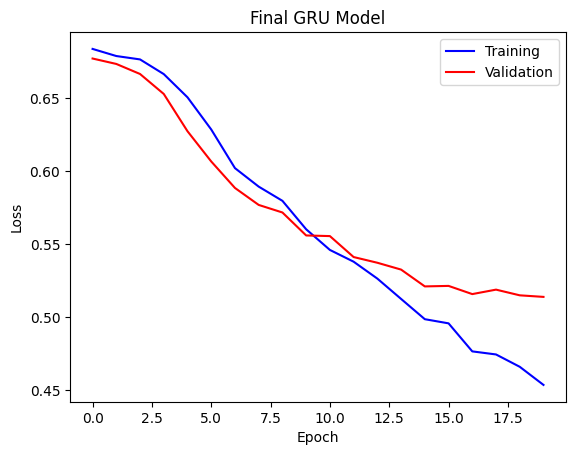

In [86]:
fig, ax = plt.subplots()
ax.plot(losses[0], 'b-', label='Training')
ax.plot(losses[1], 'r-', label='Validation')
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Final GRU Model')
fig.show()

In [87]:
predictions = []
for val_text in val_texts:
    pred = predict(model, val_text)
    if pred > 0.5:
        pred = 1 
    else:
        pred = 0
    predictions.append(pred)

0.7596848325673013
[[750 124]
 [242 407]]


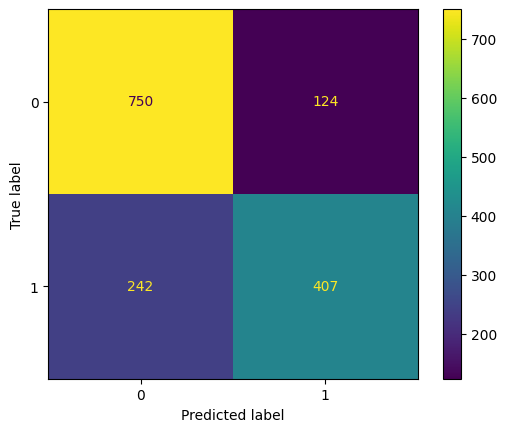

In [88]:
acc = accuracy_score(val_labels, predictions)
cm = confusion_matrix(val_labels, predictions)
print(acc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Submit Results

In [44]:
test_df['reduced_text'] = test_df['text'].apply(lambda x: process_text(x))

In [59]:
test_text = test_df['reduced_text'].to_list()
predictions = []
for val_text in test_text:
    # If text can't be tokenized, predict 0 
    if torch.tensor([vocab[token] for token in tokenizer(val_text)]).size()[0] == 0:
        pred = 0
    else:
        pred = predict(model, val_text)
    if pred > 0.5:
        pred = 1 
    else:
        pred = 0
    predictions.append(pred)
    


In [61]:
test_df['target'] = predictions

results = test_df[['id', 'target']]
results.to_csv('submission.csv', index=False)

# Conclusion

For this project, we looked at classifyi
fig, ax = plt.subplots()
ax.plot(losses[0], 'b-', label='Training')
ax.plot(losses[1], 'r-', label='Validation')
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('LSTM Model')
fig.show()
fig, ax = plt.subplots()
ax.plot(losses[0], 'b-', label='Training')
ax.plot(losses[1], 'r-', label='Validation')
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('LSTM Model')
fig.show()ng tweets to determine if they are discussing a disaster.We pefromed the following steps:

1. Preprocessed the text to remove stop words and special characters
2. We used a family of RNN models: Vanilla RNN, LSTM, and GRU.
3. From the results of running the model, we decided to tune the GRU model and use that as our final model.

This resulted in a GRU model acheiving ~76% accuracy